#### Import libraries

In [ ]:
%pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 1.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.gaussian_process.kernels import RBF

from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args

from skopt.learning import GaussianProcessRegressor

#### Import the dataset

In [ ]:
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y = True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Define the hyperparameter space

In [ ]:
param_grid = [
    Integer(10, 120, name='n_estimators'),
    Real(0.01, 0.999, name='min_samples_split'),
    Integer(1, 5, name='max_depth'),
    Categorical(['deviance', 'exponential'], name='loss')
]

#### Define the model

In [ ]:
gbm = GradientBoostingClassifier(random_state=42)

#### Define the kernel

In [ ]:
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
kernel

1**2 * RBF(length_scale=1)

#### Set up the Gaussian Process

In [ ]:
gpr = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True, noise='gaussian',
    n_restarts_optimizer=2
)

#### Define the objective function

In [ ]:
@use_named_args(param_grid)
def objective(**params):

  gbm.set_params(**params)

  value = np.mean(
      cross_val_score(
          gbm,
          X_train,
          y_train,
          cv=3,
          n_jobs=-4,
          scoring='accuracy'
      )

  )

  return -value

#### Bayesian Optimization

In [ ]:
gp_ = gp_minimize(
    objective,
    dimensions=param_grid,
    base_estimator=gpr,
    n_initial_points=5,
    acq_optimizer='sampling',
    random_state=42
)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
 

In [ ]:
"Best score=%.4f"% gp_.fun

'Best score=-0.9673'

In [ ]:
print("""Best parameters:
=========================
- n_estimators=%d
- min_samples_split=%.6f
- max_depth=%d
- loss = %s"""%(gp_.x[0],
               gp_.x[1],
               gp_.x[2],
               gp_.x[3]))

Best parameters:
- n_estimators=83
- min_samples_split=0.235860
- max_depth=1
- loss = deviance


#### Evaluate convergence

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

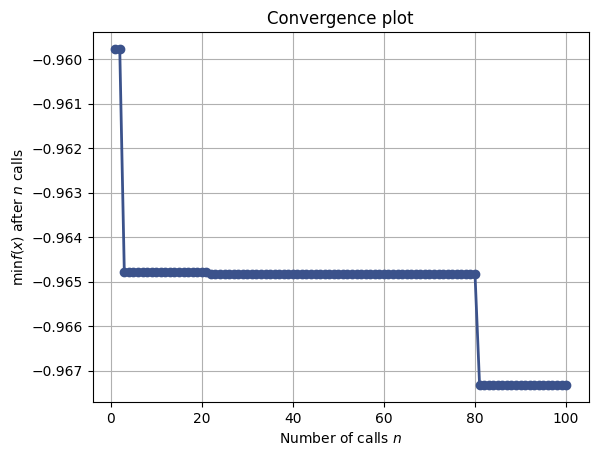

In [ ]:
plot_convergence(gp_)